# Grid Points Projection

In ECoG datasets the electrodes locations are never the same. For this reason, we establish a grid, a set of points defined in a standardised brain, and interpolate the ECoG locations to this grid such that they are common across patients.

In this notebook, we will plot these grid points and see how the features extracted from our data can be also projected into this grid space.

In order to do so, we'll read the saved features that were computed in the example_BIDS python script. Please note that in order to do so, when running the feature estimation, the settings:
```
stream.settings['postprocessing']['project_cortex'] = True
stream.settings['postprocessing']['project_subcortex'] = True
```
need to be set to ```True``` for a cortical and/or subcortical projection.


In [1]:
import os
import sys

# change root directory of the project
SCRIPT_DIR = os.path.dirname(os.path.abspath(''))
if os.path.basename(SCRIPT_DIR) == "py_neuromodulation":
    # this check is necessary, so we can also run the script from the root directory
    SCRIPT_DIR = os.path.join(SCRIPT_DIR, "examples")

sys.path.append(os.path.dirname(SCRIPT_DIR))

# Reload imports to get changes in other scripts
%load_ext autoreload
%autoreload 2

In [2]:
import py_neuromodulation as nm
from py_neuromodulation import (
    nm_analysis,
    nm_plots,
    nm_IO
)

import numpy as np
import matplotlib.pyplot as plt

## Read features from BIDS data

Here we will read the features that were estimated in example_BIDS.py. In order to do so, we need to provide the same paths to the data! In order to save time, we can use the function from `nm_IO.get_paths_example_data`.

For an example with simulated data and/or in a different format, please look into example_SimulatedData.


In [3]:
RUN_NAME, PATH_RUN, PATH_BIDS, PATH_OUT, datatype = nm_IO.get_paths_example_data()

From nm_analysis.py, we use the ```Feature_Reader``` class to load the data.

In [4]:
# init analyzer
feature_reader = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT, feature_file=RUN_NAME
)

## Grid Projection

When defining our settings, we set in the post-processing step:

```stream.settings['postprocessing']['project_cortex'] = True```
```stream.settings['postprocessing']['project_subcortex'] = True```

This means that we take all the computed features and check for every given grid point if there is any electrode channel in reach. If so, we interpolate for every grid point the channels within the range ```max_dist``` by their respective inverse distance. This gives us a projection matrix that we constantly apply, to go from the feature-channel matrix (n_features, n_channels) to the grid point matrix (n_features, n_gridpoints).

This projection matrix is precomputed (in order to save computation time), and after the feature computation (therefore as a post-processing step) it is applied such that we know the strength of every feature in every grid point. In a scenario where the data is streamed to the pypeline, the feature strength in each grid point is also computed in real time.

The cortical grid is stored in py_neuromodulation/grid_cortex.tsv and the electrodes coordinates (in a BIDS dataset) are stored in "_space-mni_electrodes.tsv".

One remark is that our cortical and subcortical grids are defined for the left hemisphere of the brain and, therefore, in the next steps the electrodes and estimated features are also going to be mapped into the this hemisphere.

From the analyzer, the user can plot the cortical projection with the function below, displaying the grid points as dots and the ECoG electrodes are crosses. The yellow grid points are the ones that are active for that specific ECoG electrode location. The inactive grid points are shown in purple.

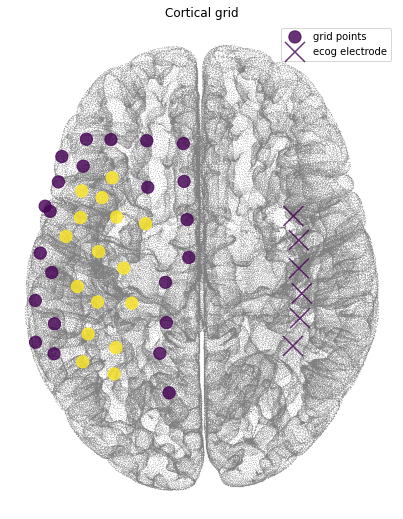

In [5]:
feature_reader.plot_cort_projection()

We can also plot only the ECoG electrodes or the grid points, with the help of the data saved in feature_reader.sidecar. In BIDS sidecar files are json files where you store additional information, here it is used to save the ECoG strip positions and the grid coordinates, which are not part of the settings and nm_channels.csv. We can check what is in the file and then use the nmplotter.plot_cortex function:

In [6]:
feature_reader.sidecar;         # remove the ; in order to display the outputs of the sidecar

In [7]:
grid_plotter = nm_plots.NM_Plot(
    ecog_strip=np.array(feature_reader.sidecar["coords"]["cortex_right"]["positions"]),
    grid_cortex=np.array(feature_reader.sidecar["grid_cortex"]),
    # grid_subcortex=np.array(feature_reader.sidecar["grid_subcortex"]),
    sess_right=feature_reader.sidecar["sess_right"],
    proj_matrix_cortex=np.array(feature_reader.sidecar["proj_matrix_cortex"]))

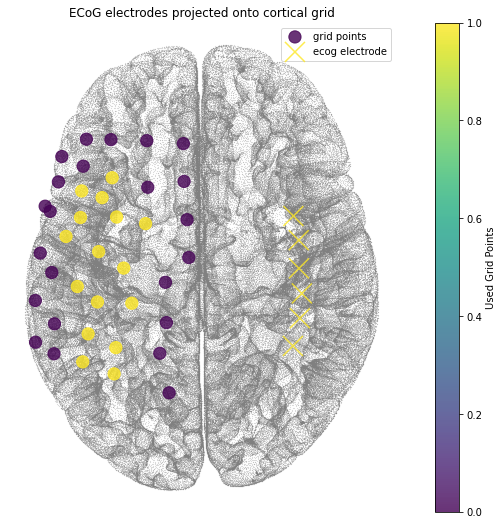

In [8]:
grid_plotter.plot_cortex(grid_color=np.sum(np.array(feature_reader.sidecar["proj_matrix_cortex"]),axis=1), lower_clim=0., upper_clim=1.0,cbar_label="Used Grid Points", title = "ECoG electrodes projected onto cortical grid")

In order to plot only the grid in the cortex or only the ECoG electrodes, we call the function plot_cortex from feature_reader.nmplotter and give the desired information.

In [9]:
feature_reader.sidecar["coords"]["cortex_right"]["positions"]

[[37.318174, -48.61012664, 61.79765474],
 [40.1598943, -37.31592983, 64.31171618],
 [40.94303578, -27.21778456, 64.09518408],
 [39.78395522, -17.00523081, 63.86618136],
 [39.68813641, -5.528024572, 61.68254254],
 [37.51915924, 4.304913414, 60.54126355]]

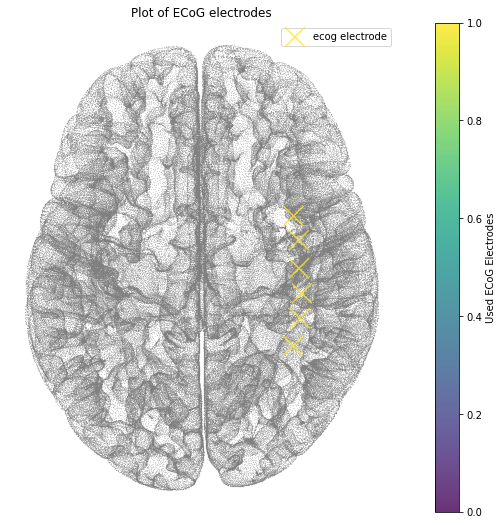

In [10]:
feature_reader.nmplotter.plot_cortex(ecog_strip=np.array(
    feature_reader.sidecar["coords"]["cortex_right"]["positions"],
),lower_clim=0., upper_clim=1.0,cbar_label="Used ECoG Electrodes", title = "Plot of ECoG electrodes")

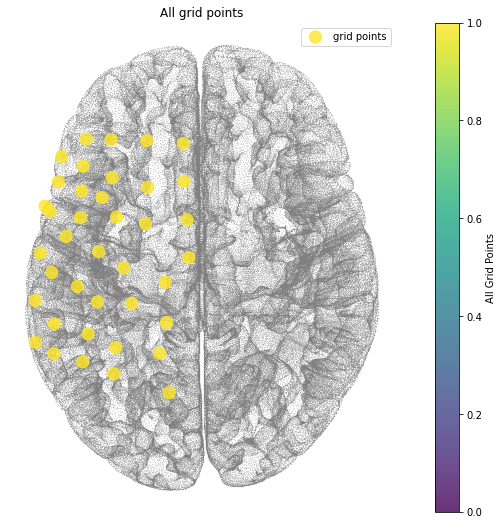

In [10]:
feature_reader.nmplotter.plot_cortex(np.array(
    feature_reader.sidecar["grid_cortex"]),
    lower_clim=0., upper_clim=1.0,cbar_label="All Grid Points", title = "All grid points")

### The Projection Matrix
To go from the feature-channel matrix (n_features, n_channels) to the grid point matrix (n_features, n_gridpoints) we need a projection matrix that has the shape (n_channels, n_gridpoints). It maps the strengths of the signals in each ECoG channel to the correspondent ones in the cortical grid. In the cell below we plot this matrix, that has the property that the column sum over channels for each grid point is either 1 or 0.

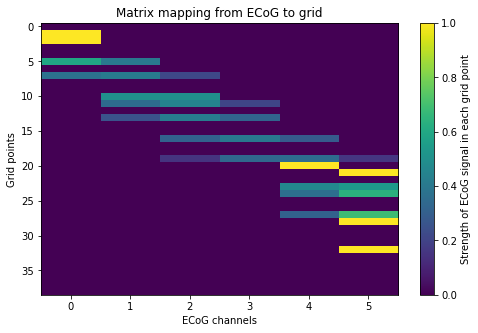

In [11]:
plt.figure(figsize=(8,5))
plt.imshow(np.array(feature_reader.sidecar['proj_matrix_cortex']), aspect = 'auto')
plt.colorbar(label = "Strength of ECoG signal in each grid point")
plt.xlabel("ECoG channels")
plt.ylabel("Grid points")
plt.title("Matrix mapping from ECoG to grid");

### Feature Plot in the Grid: An Example of Post-processing
First I take the dataframe with all the features in all time points.

In [12]:
df = feature_reader.feature_arr

In [13]:
df

,STN_RIGHT_0-STN_RIGHT_2_RawHjorth_Activity,STN_RIGHT_0-STN_RIGHT_2_RawHjorth_Mobility,STN_RIGHT_0-STN_RIGHT_2_RawHjorth_Complexity,STN_RIGHT_1-STN_RIGHT_0_RawHjorth_Activity,STN_RIGHT_1-STN_RIGHT_0_RawHjorth_Mobility,STN_RIGHT_1-STN_RIGHT_0_RawHjorth_Complexity,STN_RIGHT_2-STN_RIGHT_1_RawHjorth_Activity,STN_RIGHT_2-STN_RIGHT_1_RawHjorth_Mobility,STN_RIGHT_2-STN_RIGHT_1_RawHjorth_Complexity,ECOG_RIGHT_0-avgref_RawHjorth_Activity,...,gridcortex_19_bursts_low gamma_in_burst,gridcortex_20_bursts_low gamma_in_burst,gridcortex_21_bursts_low gamma_in_burst,gridcortex_23_bursts_low gamma_in_burst,gridcortex_24_bursts_low gamma_in_burst,gridcortex_27_bursts_low gamma_in_burst,gridcortex_28_bursts_low gamma_in_burst,gridcortex_32_bursts_low gamma_in_burst,time,MOV_LEFT_CLEAN
0,1562.615572,0.130055,9.268180,1309.885585,0.161999,7.813250,954.972812,0.158440,7.528980,3015.187531,...,0.512335,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1000.0,0.0
1,1650.862852,0.127515,9.608271,1459.539573,0.155042,8.280889,1461.150854,0.129097,9.373698,2971.704550,...,0.151080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1100.0,0.0
2,1652.156897,0.126738,9.608372,1544.130100,0.150164,8.441296,1804.154092,0.116666,10.261780,2310.213111,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1200.0,0.0
3,1410.534837,0.139946,8.763054,1693.945016,0.144589,8.815423,1883.509799,0.114110,10.542923,2461.524126,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1300.0,0.0
4,970.339813,0.170164,7.173347,1862.482956,0.137783,9.275960,1585.821876,0.124738,9.581597,2399.425432,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1400.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2805,1798.192950,0.124521,9.625863,1043.874750,0.193948,6.466615,316.059094,0.282304,4.316300,1952.582651,...,0.336585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,281500.0,0.0
2806,1700.842578,0.125639,9.520623,1074.548653,0.190561,6.550563,171.784249,0.393229,3.070565,2081.562176,...,0.336585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,281600.0,0.0
2807,1809.998158,0.123614,9.671950,1118.555243,0.188629,6.588488,189.061384,0.374456,3.241143,2433.465177,...,0.848920,1.0,1.0,1.0,1.0,1.0,1.0,1.0,281700.0,0.0
2808,2007.403359,0.119511,10.031706,1233.950160,0.179966,6.963376,197.256837,0.367166,3.296939,3051.340384,...,0.151080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,281800.0,0.0


Then we filter for only 'avgref_fft_theta', which gives us the value for fft_theta in all 6 ECoG channels over all time points. Then I take only the 6th time point - as an arbitrary choice.

In [14]:
fft_theta_oneTimePoint = np.asarray(df[df.columns[df.columns.str.contains(pat = 'avgref_fft_theta')]].iloc[5])

In [16]:
fft_theta_oneTimePoint

array([3.78454719, 3.87931868, 4.04800127, 3.89411819, 3.74335661,
       3.9566148 ])

Then the projection of the features into the grid is gonna be the color of the grid points in the plot_cortex function. That is, what I call color is the matrix multiplication of the projection matrix of the cortex and the 6 values for the fft_theta feature above.

In [17]:
grid_fft_Theta = np.array(feature_reader.sidecar["proj_matrix_cortex"]) @ fft_theta_oneTimePoint

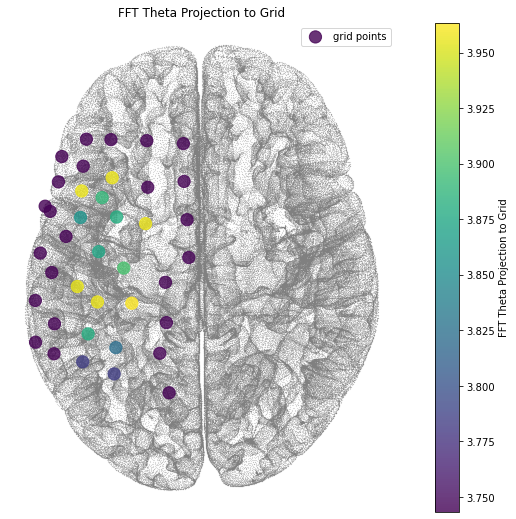

In [18]:
feature_reader.nmplotter.plot_cortex(np.array(
    feature_reader.sidecar["grid_cortex"]),grid_color = grid_fft_Theta, set_clim = True, lower_clim=min(grid_fft_Theta[grid_fft_Theta>0]), upper_clim=max(grid_fft_Theta), cbar_label="FFT Theta Projection to Grid", title = "FFT Theta Projection to Grid")

Lower and upper boundaries for clim were chosen to be the max and min values of the projection of the features (minimum value excluding zero). This can be checked in the cell below:

In [19]:
grid_fft_Theta

array([0.        , 3.78454719, 3.78454719, 0.        , 0.        ,
       3.82290051, 0.        , 3.88017836, 0.        , 0.        ,
       3.96347642, 3.95724493, 0.        , 3.95535071, 0.        ,
       0.        , 3.89904207, 0.        , 0.        , 3.87399177,
       3.74335661, 3.9566148 , 0.        , 3.85722883, 3.87939767,
       0.        , 0.        , 3.88918909, 3.9566148 , 0.        ,
       0.        , 0.        , 3.9566148 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In the plot above we can see how the intensity of the fast fourier transform in the theta band varies for each grid point in the cortex, for one specific time point.